In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('GE.csv',index_col='Date',parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-29,72.615143,74.137390,72.615143,73.887589,73.568665,11009426
2022-03-30,73.083527,74.270103,72.833725,73.832947,73.514252,7216642
2022-03-31,73.185013,73.341141,71.405151,71.428574,71.120262,10537122
2022-04-01,71.896957,72.256050,71.124123,72.201408,71.889755,7226505
2022-04-04,71.959404,72.068695,70.960190,71.834503,71.524437,6583828


In [3]:
cols = list(df)[0:1]

In [4]:
cols

['Open']

In [5]:
df1 = df[cols]

In [6]:
df1.head()

,Open
Date,
2022-03-29,72.615143
2022-03-30,73.083527
2022-03-31,73.185013
2022-04-01,71.896957
2022-04-04,71.959404


In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:xlabel='Date'>

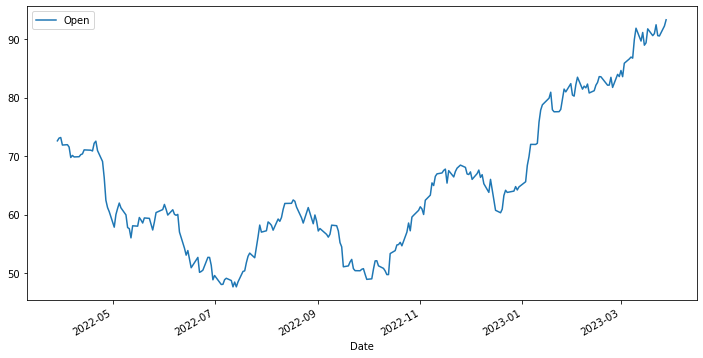

In [8]:
df1.plot(figsize=(12,6))

In [9]:
len(df1)

251

In [10]:
df1.shape

(251, 1)

In [11]:
train = df1.iloc[100:235]
test = df1.iloc[235:]

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [13]:
df1.head(),df1.tail()

(                 Open
 Date                 
 2022-03-29  72.615143
 2022-03-30  73.083527
 2022-03-31  73.185013
 2022-04-01  71.896957
 2022-04-04  71.959404,
                  Open
 Date                 
 2023-03-22  92.489998
 2023-03-23  90.629997
 2023-03-24  90.570000
 2023-03-27  92.279999
 2023-03-28  93.339996)

In [14]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [15]:
scaled_train[:10]

array([[0.27903132],
       [0.25545118],
       [0.27944501],
       [0.30467978],
       [0.32577777],
       [0.25234853],
       [0.29206239],
       [0.26413861],
       [0.21946049],
       [0.23063004]])

In [16]:

from keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
     

In [18]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.27903132 0.25545118 0.27944501]
Predict this y: 
 [[0.30467978]]


In [19]:
# We do the same thing, but now instead for 12 days
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [20]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
     

In [21]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [22]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [23]:
# fit model
model.fit(generator,epochs=20)

Epoch 1/20
123/123 [==============================] - 3s 5ms/step - loss: 0.0338
Epoch 2/20
123/123 [==============================] - 1s 5ms/step - loss: 0.0070
Epoch 3/20
123/123 [==============================] - 1s 5ms/step - loss: 0.0068
Epoch 4/20
123/123 [==============================] - 1s 5ms/step - loss: 0.0068
Epoch 5/20
123/123 [==============================] - 1s 5ms/step - loss: 0.0044
Epoch 6/20
123/123 [==============================] - 1s 5ms/step - loss: 0.0038
Epoch 7/20
123/123 [==============================] - 1s 4ms/step - loss: 0.0039
Epoch 8/20
123/123 [==============================] - 1s 5ms/step - loss: 0.0035
Epoch 9/20
123/123 [==============================] - 1s 5ms/step - loss: 0.0033
Epoch 10/20
123/123 [==============================] - 1s 5ms/step - loss: 0.0029
Epoch 11/20
123/123 [==============================] - 1s 5ms/step - loss: 0.0032
Epoch 12/20
123/123 [==============================] - 1s 5ms/step - loss: 0.0028
Epoch 13/20
123/123 [====

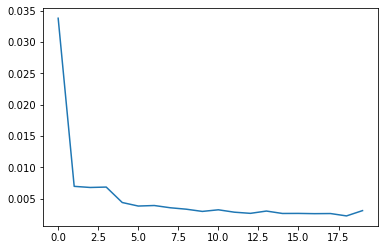

In [24]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [25]:
last_train_batch = scaled_train[-n_input:]

In [26]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [27]:
model.predict(last_train_batch)
     

1/1 [==============================] - 0s 230ms/step


array([[0.9389096]], dtype=float32)

In [28]:
scaled_test[0]

array([1.00847891])

In [29]:

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 33ms/step


In [30]:
test_predictions

[array([0.9389096], dtype=float32),
 array([0.93550825], dtype=float32),
 array([0.93190575], dtype=float32),
 array([0.92737764], dtype=float32),
 array([0.9231267], dtype=float32),
 array([0.9194202], dtype=float32),
 array([0.9158222], dtype=float32),
 array([0.91240793], dtype=float32),
 array([0.9091551], dtype=float32),
 array([0.90602505], dtype=float32),
 array([0.90316457], dtype=float32),
 array([0.90053076], dtype=float32),
 array([0.898079], dtype=float32),
 array([0.89581203], dtype=float32),
 array([0.8937045], dtype=float32),
 array([0.8917461], dtype=float32)]

In [31]:
true_predictions = scaler.inverse_transform(test_predictions)

In [32]:
test['Predictions'] = true_predictions

C:\Users\Ankit Rawat\AppData\Local\Temp\ipykernel_4600\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [33]:
test.head(15)

,Open,Predictions
Date,,
2023-03-07,86.959999,84.334404
2023-03-08,86.769997,84.206035
2023-03-09,89.959999,84.070074
2023-03-10,91.900002,83.899180
2023-03-13,89.699997,83.738747
2023-03-14,91.169998,83.598860
2023-03-15,88.989998,83.463070
2023-03-16,89.400002,83.334213
2023-03-17,91.790001,83.211448


<AxesSubplot:xlabel='Date'>

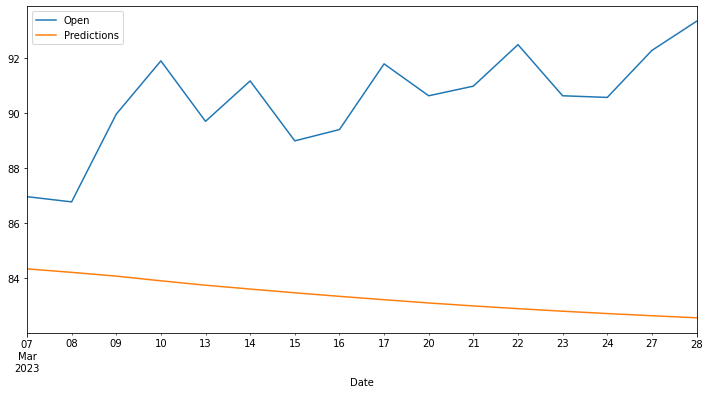

In [36]:
test.plot(figsize=(12,6))


In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Open'],test['Predictions']))
print(rmse)
     

7.4650206223516005
